# Planets and Moons Dataset - AI in Space 🌌 🛰 ☄ 🔭
---
## Dataset
The Planets and Moons dataset consists of approximately 8 confirmed planets, 2 dwarf planets, and 1 Earth's moon, the Moon. It includes 11 classes in total.

There are 149 photos of each planet in 3D. All photos are optimized and ready for convolution for AI applications.

Annotations are licensed by Emirhan BULUT under a CC BY-NC 4.0 license. This software and dataset cannot be used for commercial purposes without permission.

Images are listed as licensed CC BY-NC 4.0. The dataset was collected by Emirhan BULUT. The dataset was compiled and collected in accordance with the sensitivity parameters.

## Import to Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import *
from tensorflow.keras import layers, models
from tensorflow import keras
from tensorflow.keras import Sequential
import random
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import VGG16

## 📋 Data Preparing

In [2]:
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    samplewise_center=False,
    featurewise_std_normalization=True,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1.0/255.0,
    preprocessing_function=None,
    data_format=None,
    dtype=None,
    validation_split=0.2)
train_generator = train_datagen.flow_from_directory("../input/planets-and-moons-dataset-ai-in-space/Planets_Moons_Data/Planets and Moons",target_size=(256, 256),
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    interpolation="lanczos",
                                                    subset="training")
test_generator = train_datagen.flow_from_directory("../input/planets-and-moons-dataset-ai-in-space/Planets_Moons_Data/Planets and Moons",target_size=(256, 256),
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    interpolation="lanczos",
                                                    subset="validation")

Found 1319 images belonging to 11 classes.
Found 319 images belonging to 11 classes.


Found 1638 files belonging to 11 classes.


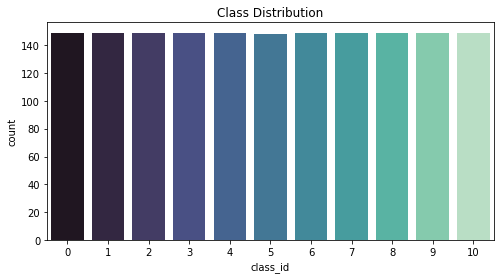

In [3]:
dataset_dir = "../input/planets-and-moons-dataset-ai-in-space/Planets_Moons_Data/Planets and Moons"

raw_ds = image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32, 
    shuffle=False
)

file_paths = raw_ds.file_paths
labels = []
for _, y_batch in raw_ds.unbatch():
    labels.append(int(y_batch.numpy()))

label_counts = Counter(labels)
df_counts = pd.DataFrame(list(label_counts.items()), columns=['class_id', 'count'])

plt.figure(figsize=(8,4))
sns.barplot(data=df_counts, x='class_id', y='count', palette='mako')
plt.title("Class Distribution")
plt.show()

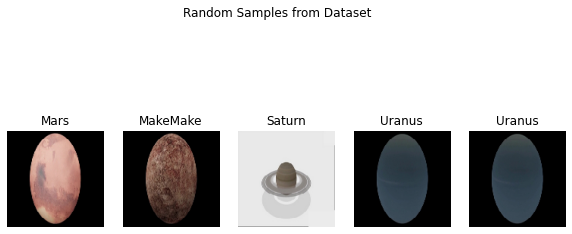

In [4]:
plt.figure(figsize=(10, 5))
for i in range(5):
    path = random.choice(file_paths)
    img = load_img(path, target_size=(128, 128))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(os.path.basename(os.path.dirname(path)))
    plt.axis("off")
plt.suptitle("Random Samples from Dataset")
plt.show()

In [5]:
df = pd.DataFrame({'file_path': file_paths, 'label': labels})
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

os.makedirs("folds", exist_ok=True)

for fold, (train_idx, test_idx) in enumerate(skf.split(df['file_path'], df['label'])):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    
    val_df = train_df.sample(frac=0.2, random_state=42)
    train_df = train_df.drop(val_df.index)

    # Save to CSV
    train_df.to_csv(f"folds/fold_{fold}_train.csv", index=False)
    val_df.to_csv(f"folds/fold_{fold}_val.csv", index=False)
    test_df.to_csv(f"folds/fold_{fold}_test.csv", index=False)

print("✅ Saved stratified 5-fold splits as CSVs!")

✅ Saved stratified 5-fold splits as CSVs!


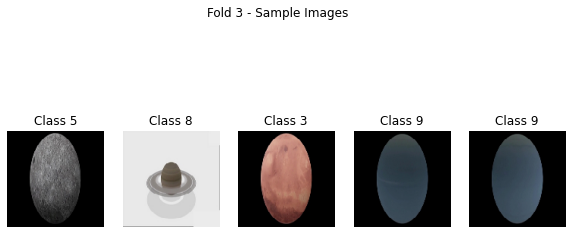

In [6]:
fold_num = 3
sample_df = pd.read_csv(f"folds/fold_{fold_num}_train.csv")

plt.figure(figsize=(10, 5))
for i, (_, row) in enumerate(sample_df.sample(5).iterrows()):
    plt.subplot(1, 5, i+1)
    img = load_img(row['file_path'], target_size=(128, 128))
    plt.imshow(img)
    plt.title(f"Class {row['label']}")
    plt.axis("off")
plt.suptitle(f"Fold {fold_num} - Sample Images")
plt.show()

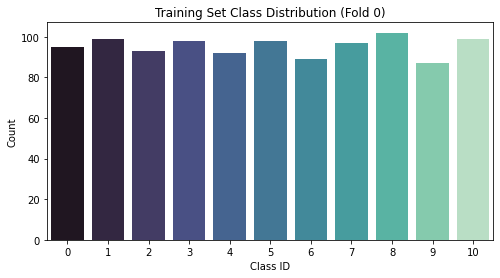

Class counts:
 0      95
1      99
2      93
3      98
4      92
5      98
6      89
7      97
8     102
9      87
10     99
Name: label, dtype: int64


In [7]:
train_df = pd.read_csv("folds/fold_3_train.csv")

class_counts = train_df['label'].value_counts().sort_index()

plt.figure(figsize=(8,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="mako")
plt.title("Training Set Class Distribution (Fold 0)")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.show()

print("Class counts:\n", class_counts)

It is blanced for all classes

In [8]:
train_df = pd.read_csv("folds/fold_0_train.csv")
val_df = pd.read_csv("folds/fold_0_val.csv")
test_df = pd.read_csv("folds/fold_0_test.csv")

train_df["label"] = train_df["label"].astype(str)
val_df["label"] = val_df["label"].astype(str)
test_df["label"] = test_df["label"].astype(str)

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='file_path', y_col='label',
                                              target_size=(224, 224), class_mode='categorical', batch_size=32)
val_gen = val_datagen.flow_from_dataframe(val_df, x_col='file_path', y_col='label',
                                          target_size=(224, 224), class_mode='categorical', batch_size=32)
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='file_path', y_col='label',
                                            target_size=(224, 224), class_mode='categorical', batch_size=32, shuffle=False)

num_classes = len(train_gen.class_indices)

Found 1048 validated image filenames belonging to 11 classes.
Found 262 validated image filenames belonging to 11 classes.
Found 328 validated image filenames belonging to 11 classes.


In [9]:
def build_alexnet(input_shape=(224, 224, 3), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(96, (11,11), strides=4, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3,3), strides=2),

        layers.Conv2D(256, (5,5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3,3), strides=2),

        layers.Conv2D(384, (3,3), padding='same', activation='relu'),
        layers.Conv2D(384, (3,3), padding='same', activation='relu'),
        layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D((3,3), strides=2),

        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
def build_vgg16(input_shape=(224,224,3), num_classes=10):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    x = layers.Flatten()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
alexnet = build_alexnet(num_classes=num_classes)
vgg16 = build_vgg16(num_classes=num_classes)

58900480/58889256 [==============================] - 3s 0us/step


In [12]:
# AlexNet
history_alex = alexnet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

Epoch 1/10
33/33 [==============================] - 19s 352ms/step - loss: 3.7231 - accuracy: 0.1479 - val_loss: 2.2018 - val_accuracy: 0.1641
Epoch 2/10
33/33 [==============================] - 12s 357ms/step - loss: 2.1350 - accuracy: 0.1737 - val_loss: 2.1180 - val_accuracy: 0.1641
Epoch 3/10
33/33 [==============================] - 12s 351ms/step - loss: 2.1115 - accuracy: 0.1803 - val_loss: 2.1104 - val_accuracy: 0.1870
Epoch 4/10
33/33 [==============================] - 12s 353ms/step - loss: 2.1073 - accuracy: 0.1689 - val_loss: 2.1109 - val_accuracy: 0.1641
Epoch 5/10
33/33 [==============================] - 12s 354ms/step - loss: 2.1060 - accuracy: 0.1603 - val_loss: 2.1126 - val_accuracy: 0.1794
Epoch 6/10
33/33 [==============================] - 12s 355ms/step - loss: 2.1056 - accuracy: 0.1765 - val_loss: 2.1045 - val_accuracy: 0.1794
Epoch 7/10
33/33 [==============================] - 12s 350ms/step - loss: 2.1143 - accuracy: 0.1765 - val_loss: 2.0147 - val_accuracy: 0.2710

In [13]:
# VGG16
history_vgg = vgg16.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

Epoch 1/10
33/33 [==============================] - 18s 446ms/step - loss: 3.2601 - accuracy: 0.4055 - val_loss: 0.5330 - val_accuracy: 0.8435
Epoch 2/10
33/33 [==============================] - 12s 367ms/step - loss: 0.7135 - accuracy: 0.7462 - val_loss: 0.2527 - val_accuracy: 0.9656
Epoch 3/10
33/33 [==============================] - 12s 361ms/step - loss: 0.4858 - accuracy: 0.8282 - val_loss: 0.1859 - val_accuracy: 0.9237
Epoch 4/10
33/33 [==============================] - 12s 361ms/step - loss: 0.3811 - accuracy: 0.8798 - val_loss: 0.1415 - val_accuracy: 0.9733
Epoch 5/10
33/33 [==============================] - 12s 373ms/step - loss: 0.2649 - accuracy: 0.9189 - val_loss: 0.0882 - val_accuracy: 0.9809
Epoch 6/10
33/33 [==============================] - 12s 360ms/step - loss: 0.2172 - accuracy: 0.9380 - val_loss: 0.0514 - val_accuracy: 0.9809
Epoch 7/10
33/33 [==============================] - 12s 362ms/step - loss: 0.1860 - accuracy: 0.9494 - val_loss: 0.0646 - val_accuracy: 0.9809

In [14]:
def evaluate_model(model, test_gen, name="Model"):
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_gen.classes

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n📊 {name} Performance:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))
    
    return acc, prec, rec, f1

alex_results = evaluate_model(alexnet, test_gen, "AlexNet")
vgg_results = evaluate_model(vgg16, test_gen, "VGG16")

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: 


📊 AlexNet Performance:
Accuracy : 0.1799
Precision: 0.0976
Recall   : 0.1799
F1-score : 0.1051

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.10      1.00      0.18        30
          10       0.00      0.00      0.00        30
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00        29
           5       0.00      0.00      0.00        30
           6       0.00      0.00      0.00        30
           7       0.00      0.00      0.00        30
           8       1.00      1.00      1.00        29
           9       0.00      0.00      0.00        30

    accuracy                           0.18       328
   macro avg       0.10      0.18      0.11       328
weighted avg       0.10      0.18      0.11       328


📊 VGG16 Performance:
Accuracy : 0.9970
Precision: 0.9971


In [15]:
results = pd.DataFrame({
    "Model": ["AlexNet", "VGG16"],
    "Accuracy": [alex_results[0], vgg_results[0]],
    "Precision": [alex_results[1], vgg_results[1]],
    "Recall": [alex_results[2], vgg_results[2]],
    "F1-score": [alex_results[3], vgg_results[3]]
})
print(results)

     Model  Accuracy  Precision    Recall  F1-score
0  AlexNet  0.179878   0.097592  0.179878  0.105095
1    VGG16  0.996951   0.997053  0.996951  0.996951
